In [1]:
#Importing dependencies
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from pymongo import MongoClient
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# connect to mongodb
mongo = MongoClient(port=27017)

for dbname in mongo.list_database_names():
    if dbname == "texasSchoolsDB":
        print(f'{dbname} <----------')
    else:
        print(dbname)

In [3]:
# find collections
db = mongo["texasSchoolsDB"]
db.list_collection_names()

['teachers20_21',
 'school_info',
 'scores_finances',
 'schools_2022_to_2023_geojson',
 'demographics',
 'staar20_21',
 'coordinates',
 'scores_coordinates',
 'account_ratings22',
 'tor20_21',
 'satscores20_21',
 'scores_finances_coordinates',
 'current_districts_geojson',
 'staar19_20',
 'DISTRICTS_INFO_2020_21',
 'NN_model',
 'demographic20_21']

# Data Processing

In [4]:
# Grab collections from mongodb and convert it to a pandas dataframe
collection1 = db.DISTRICTS_INFO_2020_21
collection2 = db.staar20_21

all_info = pd.DataFrame(list(collection1.find()))
staar19 = pd.DataFrame(list(collection2.find()))

In [5]:
# Merge previous STAAR data with current District info
completedf = pd.merge(staar19, all_info, on='DISTRICT NAME', how="inner")

In [6]:
# calculate change in STAAR SCORES and add to DB
completedf['Change in STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD'] = completedf['STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD_y'] - completedf['STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD_x']
completedf['Change in STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE'] = completedf['STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y'] - completedf['STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE_x']
completedf['Change in STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE'] = completedf['STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y'] - completedf['STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x']

In [7]:
completedf.columns.to_list()

['_id_x',
 'DISTRICT NAME',
 'TOTAL NUMBER OF SCHOOLS_x',
 'TOTAL STUDENTS_x',
 'STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % SCIENCE AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % SCIENCE AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % SCIENCE AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % SOCIAL STUDIES AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 ' STAAR: % SOCIAL STUDIES AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 '

In [8]:
# Drop the non-beneficial columns 
completedf = completedf.drop(columns=['_id_x',
 'DISTRICT NAME',
 'TOTAL NUMBER OF SCHOOLS_x',
 'TOTAL STUDENTS_x',
 'STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % SCIENCE AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % SCIENCE AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % SCIENCE AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % SOCIAL STUDIES AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 ' STAAR: % SOCIAL STUDIES AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % SOCIAL STUDIES AT MASTERS GRADE LEVEL STANDARD_x',
 ' STAAR: % AFRICAN AMERICAN AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % AFRICAN AMERICAN AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % AFRICAN AMERICAN AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % HISPANIC AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % HISPANIC AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % HISPANIC AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % WHITE AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % WHITE AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % WHITE AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % ASIAN AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ASIAN AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ASIAN AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % TWO OR MORE RACES AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % TWO OR MORE RACES AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 ' STAAR: % TWO OR MORE RACES AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % ECONOMICALLY DISADVANTAGED AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ECONOMICALLY DISADVANTAGED AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ECONOMICALLY DISADVANTAGED AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % AMERICAN INDIAN AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % AMERICAN INDIAN AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % AMERICAN INDIAN AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % PACIFIC ISLANDER AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % PACIFIC ISLANDER AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % PACIFIC ISLANDER AT MASTERS GRADE LEVEL STANDARD_x',
 '_id_y',
 'DISTRICT NUMBER',
 'COUNTY NUMBER AND NAME',
 'EDUCATION SERVICE CENTER REGION',
 'TOTAL NUMBER OF SCHOOLS_y',
 'STUDENTS: % AFRICAN AMERICAN',
 'STUDENTS: % HISPANIC',
 'STUDENTS: % WHITE',
 'STUDENTS: % AMERICAN INDIAN',
 'STUDENTS: % ASIAN',
 'STUDENTS: % PACIFIC ISLANDER',
 'STUDENTS: % TWO OR MORE RACES',
 'STUDENTS: % ECONOMICALLY DISADVANTAGED',
 'STUDENTS: % ENGLISH LEARNERS (EL)',
 'STUDENTS: % SPECIAL EDUCATION',
 'STUDENTS: % BILINGUAL/ESL EDUCATION',
 'STUDENTS: % CAREER & TECHNICAL EDUCATION',
 'STUDENTS: % GIFTED & TALENTED EDUCATION',
 'ANNUAL DROPOUT RATE GR',
 '5-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2020) DISTRICT EXCL',
 ' 6-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2019) DISTRICT EXCL',
 'ANNUAL GRADUATE COUNT (2020-21)',
 'ANNUAL RHSP/DAP/FHSP-E/FHSP-DLA GRADUATE COUNT (2020-21)',
 'STAAR: % SCIENCE AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % SCIENCE AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % SCIENCE AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % SOCIAL STUDIES AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 ' STAAR: % SOCIAL STUDIES AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % SOCIAL STUDIES AT MASTERS GRADE LEVEL STANDARD_y',
 ' STAAR: % AFRICAN AMERICAN AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % AFRICAN AMERICAN AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % AFRICAN AMERICAN AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % HISPANIC AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % HISPANIC AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % HISPANIC AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % WHITE AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % WHITE AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % WHITE AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % ASIAN AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ASIAN AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ASIAN AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % TWO OR MORE RACES AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % TWO OR MORE RACES AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 ' STAAR: % TWO OR MORE RACES AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % ECONOMICALLY DISADVANTAGED AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ECONOMICALLY DISADVANTAGED AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ECONOMICALLY DISADVANTAGED AT MASTERS GRADE LEVEL STANDARD_y',
 'SAT-AVERAGE SCORE (2021-2020)',
 'TOTAL STAFF FTE',
 'TOTAL TEACHER FTE',
 'STAFF: % CENTRAL ADMINISTRATIVE',
 'STAFF: % SCHOOL ADMINISTRATIVE',
 'STAFF: % PROFESSIONAL SUPPORT',
 'STAFF: % TEACHERS',
 'STAFF: % EDUCATIONAL AIDES',
 'STAFF: % AUXILIARY',
 'AVERAGE SALARY: CENTRAL ADMINISTRATIVE',
 'AVERAGE SALARY: SCHOOL ADMINISTRATIVE',
 'AVERAGE SALARY: PROFESSIONAL SUPPORT',
 'AVERAGE SALARY: TEACHER',
 'STAFF: % MINORITY',
 'NUMBER OF STUDENTS PER TOTAL STAFF',
 'NUMBER OF STUDENTS PER TEACHER',
 'TEACHER: % WITH 5 OR FEWER YEARS OF EXPERIENCE',
 'TEACHER: AVERAGE YEARS OF EXPERIENCE',
 'TEACHER: % WITH ADVANCED DEGREES',
 'TEACHER: TURNOVER RATE',
 'TEACHER: % AFRICAN AMERICAN',
 'TEACHER: % HISPANIC',
 'TEACHER: % WHITE',
 'TEACHER: % AMERICAN INDIAN',
 'TEACHER: % ASIAN',
 'TEACHER: % PACIFIC ISLANDER',
 'TEACHER: % TWO OR MORE RACES',
 'TEACHER: % REGULAR EDUCATION',
 'TEACHER: % SPECIAL EDUCATION',
 'TEACHER: % COMPENSATORY EDUCATION',
 'TEACHER: % BILINGUAL/ESL EDUCATION',
 'TEACHER: % CAREER & TECHNICAL EDUCATION',
 'TEACHER: % OTHER EDUCATION (INCLUDES G & T)',
 'TAXABLE VALUE PER PUPIL (2019 TAX YEAR)',
 'LOCALLY ADOPTED TAX RATE (2020 TAX YEAR)',
 'TOTAL OPERATING AND OTHER REVENUE (2020-21)',
 'Total OPERATING AND OTHER REVENUE PER PUPIL',
 'Total OPERATING REVENUE (2020-21)',
 'REVENUE: % STATE',
 'REVENUE: % LOCAL AND OTHER',
 'REVENUE: % FEDERAL',
 'TOTAL OTHER REVENUE(2020-21)',
 'FUND BALANCE (FOR ISDS)',
 'NET ASSETS (CHARTER SCHOOLS)',
 'TOTAL ACTUAL EXPENDITURES (2020-21)',
 'TOTAL ACTUAL OPERATING EXPENDITURES (2020-21)',
 'TOTAL ACTUAL OPERATING EXPENDITURES PER PUPIL',
 'EXPENDITURE: % INSTRUCTIONAL',
 'EXPENDITURE: % CENTRAL ADMINISTRATIVE',
 'EXPENDITURE: % SCHOOL LEADERSHIP',
 'EXPENDITURE: % PLANT SERVICES',
 'EXPENDITURE: % OTHER OPERATING',
 'TOTAL ACTUAL INSTRUCTIONAL EXPENDITURES',
 'TOTAL ACTUAL INSTRUCTIONAL EXPENDITURES PER PUPIL',
 ' EXPENDITURE: % BASIC EDUCATION SERVICES',
 'EXPENDITURE: % SPECIAL EDUCATION',
 'EXPENDITURE: % STATE COMPENSATORY EDUCATION',
 'EXPENDITURE: % BILINGUAL/ESL EDUCATION',
 'EXPENDITURE: % CAREER & TECHNICAL EDUCATION',
 ' EXPENDITURE: % GIFTED & TALENTED EDUCATION',
 'EXPENDITURE: % ATHLETICS/RELATED ACTIVITIES',
 'EXPENDITURE: % HIGH SCHOOL ALLOTMENT',
 'EXPENDITURE: % PREKINDERGARTEN',
 'EXPENDITURE: % UN-ALLOCATED',
 'DISTRICT SIZE',
 'COMMUNITY TYPE',
 'PROPERTY WEALTH',
 'TAX RATE',
 'STAAR: % AMERICAN INDIAN AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % AMERICAN INDIAN AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % AMERICAN INDIAN AT MASTERS GRADE LEVEL STANDARD_y',
 'ACT-AVERAGE SCORE (2021-2020)',
 'STAAR: % PACIFIC ISLANDER AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % PACIFIC ISLANDER AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % PACIFIC ISLANDER AT MASTERS GRADE LEVEL STANDARD_y',
   'STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD_y',
  'Change in STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD',
 'Change in STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE',
 'Change in STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE',])

In [10]:
completedf.head()

,DISTRICT ACCOUNTABILITY RATINGS,TOTAL STUDENTS_y,ATTENDANCE RATE (2020-21),4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL,STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y,STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y,STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y,STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y,STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y,STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y,COLLEGE ADMISSIONS: % TESTED (2020-2021),COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)
0,A,574,96.7,100.0,81.0,67.0,39.0,88.0,65.0,34.0,58.3,19.0
1,A,1150,96.0,100.0,85.0,64.0,34.0,84.0,49.0,23.0,51.6,27.7
2,A,808,95.4,95.2,84.0,63.0,24.0,85.0,57.0,26.0,92.7,36.8
3,A,342,95.8,95.8,87.0,67.0,30.0,94.0,69.0,27.0,87.0,15.0
4,B,3360,93.7,99.0,72.0,48.0,20.0,75.0,44.0,20.0,43.3,49.4


In [11]:
completedf.columns.to_list()

['DISTRICT ACCOUNTABILITY RATINGS',
 'TOTAL STUDENTS_y',
 'ATTENDANCE RATE (2020-21)',
 '4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL',
 'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y',
 'COLLEGE ADMISSIONS: % TESTED (2020-2021)',
 'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)']

In [12]:
# convert columns to Numeric
columns_to_convert = ['TOTAL STUDENTS_y',
 'ATTENDANCE RATE (2020-21)',
 'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y',
 'COLLEGE ADMISSIONS: % TESTED (2020-2021)',
 'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)',
  '4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL']

completedf[columns_to_convert] = completedf[columns_to_convert].replace({',': '', '%': ''}, regex=True).apply(pd.to_numeric, errors='coerce')

In [13]:
completedf=completedf.dropna()

# Compile, Train, and Evaluate Model

In [14]:
# Remove 'DISTRICT ACCOUNTABILITY RATINGS' target from features data
completedf['DISTRICT ACCOUNTABILITY RATINGS'] = completedf['DISTRICT ACCOUNTABILITY RATINGS'].replace({
    'Not Rated: Data Under Review': 'Not Rated',
    'Not Rated: Senate Bill 1365': 'Not Rated'
})

# Remove rows where 'DISTRICT ACCOUNTABILITY RATINGS' is 'Not Rated'
completedf = completedf[completedf['DISTRICT ACCOUNTABILITY RATINGS'] != 'Not Rated']

# Now 'completedf' only contains rows where the ratings are A, B, or C
completedf.head()

,DISTRICT ACCOUNTABILITY RATINGS,TOTAL STUDENTS_y,ATTENDANCE RATE (2020-21),4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL,STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y,STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y,STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y,STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y,STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y,STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y,COLLEGE ADMISSIONS: % TESTED (2020-2021),COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)
0,A,574,96.7,100.0,81.0,67.0,39.0,88.0,65.0,34.0,58.3,19.0
1,A,1150,96.0,100.0,85.0,64.0,34.0,84.0,49.0,23.0,51.6,27.7
2,A,808,95.4,95.2,84.0,63.0,24.0,85.0,57.0,26.0,92.7,36.8
3,A,342,95.8,95.8,87.0,67.0,30.0,94.0,69.0,27.0,87.0,15.0
4,B,3360,93.7,99.0,72.0,48.0,20.0,75.0,44.0,20.0,43.3,49.4


In [15]:
# Preparing the features and labels
X = completedf.drop(columns=['DISTRICT ACCOUNTABILITY RATINGS'])
y = completedf['DISTRICT ACCOUNTABILITY RATINGS']

In [16]:
# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and fit the LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Save the fitted LabelEncoder for later use
joblib.dump(label_encoder, 'label_encoder.joblib')

# Verify the classes have been encoded as expected
print(label_encoder.classes_) 

# Initialize and fit the StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


['A' 'B' 'C']


In [17]:
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
print(X_train_scaled.shape)

(834, 11)


In [18]:
# Save the scaler to disk
joblib.dump(scaler, 'scaler.gz')

['scaler.gz']

In [19]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=80, activation="relu", input_dim=11),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=3, activation='softmax')  # 4 classes: A, B, C
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Print model summary
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │         8,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,653 (57.24 KB)

 Trainable params: 14,653 (57.24 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
model.fit(X_train_scaled, y_train_encoded, epochs=15, batch_size=32, validation_split=0.2)


Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3177 - loss: 1.0743 - val_accuracy: 0.7126 - val_loss: 0.7743
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7331 - loss: 0.7318 - val_accuracy: 0.7605 - val_loss: 0.6636
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7278 - loss: 0.6791 - val_accuracy: 0.7784 - val_loss: 0.6134
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7713 - loss: 0.6005 - val_accuracy: 0.7784 - val_loss: 0.6231
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7882 - loss: 0.5389 - val_accuracy: 0.7725 - val_loss: 0.6071
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7737 - loss: 0.5601 - val_accuracy: 0.7904 - val_loss: 0.5967
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7996 - loss: 0.5155 - val_accuracy: 0.7784 - val_loss: 0.5889
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7963 - loss: 0.5073 - val_accuracy: 0.7964 - val_loss:

In [21]:
# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

7/7 - 0s - 3ms/step - accuracy: 0.7847 - loss: 0.5548
Loss: 0.5547751188278198, Accuracy: 0.7846890091896057


## Confusion Matrix and Classification Report

In [22]:
# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Predict classes using the test data
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Generate a confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
class_report = classification_report(y_test_encoded, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


7/7 - 0s - 3ms/step - accuracy: 0.7847 - loss: 0.5548
Loss: 0.5547751188278198, Accuracy: 0.7846890091896057
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Confusion Matrix:
[[62 11  0]
 [16 99  3]
 [ 0 15  3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        73
           1       0.79      0.84      0.81       118
           2       0.50      0.17      0.25        18

    accuracy                           0.78       209
   macro avg       0.70      0.62      0.63       209
weighted avg       0.77      0.78      0.77       209



In [23]:
#save NN

model.save("ISD_Accountability.keras")

# Correlation Matrix

In [24]:

# Convert numeric columns that are read as strings to numeric, handling errors
numeric_columns = [
    'TOTAL STUDENTS_y',
    'ATTENDANCE RATE (2020-21)',
    '4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL',
    'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
    'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
    'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y',
    'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
    'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
    'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y',
    'COLLEGE ADMISSIONS: % TESTED (2020-2021)',
    'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)'
]
for column in numeric_columns:
    completedf[column] = pd.to_numeric(completedf[column], errors='coerce')


In [25]:
# Calculate the correlation matrix for numeric columns only
correlation_matrix = completedf[numeric_columns].corr()
print(correlation_matrix)

                                                    TOTAL STUDENTS_y  \
TOTAL STUDENTS_y                                            1.000000   
ATTENDANCE RATE (2020-21)                                   0.006133   
4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 202...         -0.074853   
STAAR: % ELA/READING AT APPROACHES GRADE LEVEL ...         -0.060010   
STAAR: % ELA/READING AT MEETS GRADE LEVEL STAND...          0.004684   
STAAR: % ELA/READING AT MASTERS GRADE LEVEL STA...          0.071820   
STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL ...         -0.051495   
STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STAND...          0.014768   
STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STA...          0.063683   
COLLEGE ADMISSIONS: % TESTED (2020-2021)                    0.139405   
COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-...          0.130976   

                                                    ATTENDANCE RATE (2020-21)  \
TOTAL STUDENTS_y                                      

In [26]:
# Get a list of DataFrame columns
print(completedf.columns.tolist())

['DISTRICT ACCOUNTABILITY RATINGS', 'TOTAL STUDENTS_y', 'ATTENDANCE RATE (2020-21)', '4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL', 'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y', 'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y', 'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y', 'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y', 'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y', 'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y', 'COLLEGE ADMISSIONS: % TESTED (2020-2021)', 'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)']


In [27]:
completedf.rename(columns={
    'DISTRICT ACCOUNTABILITY RATINGS': 'ACCOUNTABILITY RATINGS',
    'TOTAL STUDENTS_y': 'TOTAL STUDENTS',
    'ATTENDANCE RATE (2020-21)': 'ATTENDANCE',
    '4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL': 'GRADUATION RATE',
    'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y': '% ELA/READING AT APPROACHES GRADE LEVEL',
    'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y': '% ELA/READING AT MEETS GRADE LEVEL STANDARD',
    'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y': ' % ELA/READING AT MASTERS GRADE LEVEL',
    'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y': '% MATH AT APPROACHES GRADE LEVEL',
    'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y': '% MATH AT MEETS GRADE LEVEL',
    'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y': ' % MATHEMATICS AT MASTERS GRADE',
    'COLLEGE ADMISSIONS: % TESTED (2020-2021)': 'COLLEGE ADMISSIONS: % TESTED',
    'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)': 'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION',
    'Change in STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD': 'Change in STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL',
    'Change in STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE': 'Change in STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL',
    'Change in STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE': 'Change in STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL'
}, inplace=True)

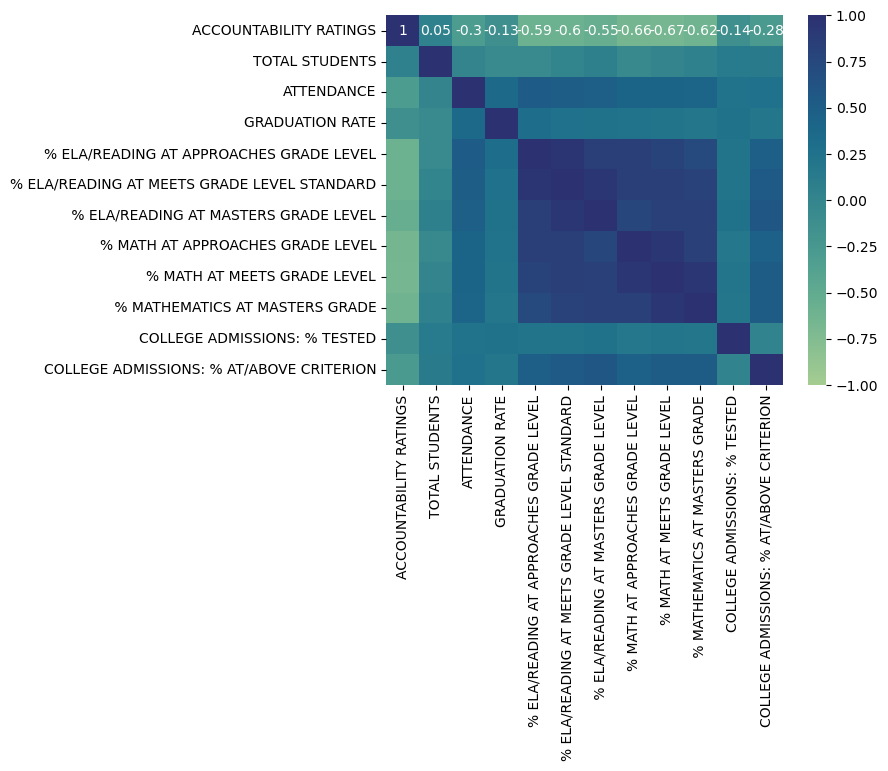

In [28]:
# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# Check if 'ACCOUNTABILITY RATINGS' needs encoding
if completedf['ACCOUNTABILITY RATINGS'].dtype == object:
    completedf['ACCOUNTABILITY RATINGS'] = label_encoder.fit_transform(completedf['ACCOUNTABILITY RATINGS'])

# Now compute the correlation matrix
matrix = completedf.corr().round(2)

# Plotting the heatmap
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, cmap='crest')
plt.show()

In [113]:
plt.savefig('heatmap.png')

<Figure size 640x480 with 0 Axes>

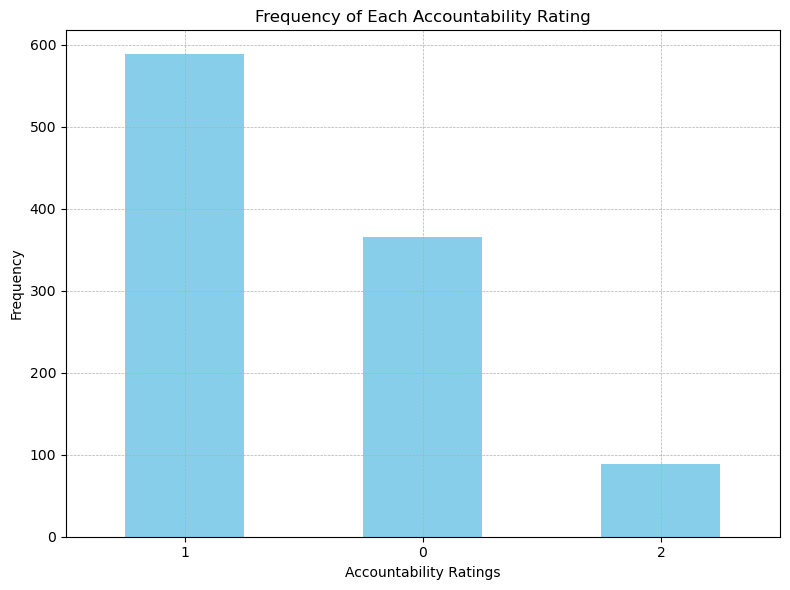

In [29]:
# Count the frequency of each rating
rating_counts = completedf['ACCOUNTABILITY RATINGS'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
rating_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Accountability Rating')
plt.xlabel('Accountability Ratings')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotates labels to horizontal
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.savefig('accountability_freq.png')
plt.show()

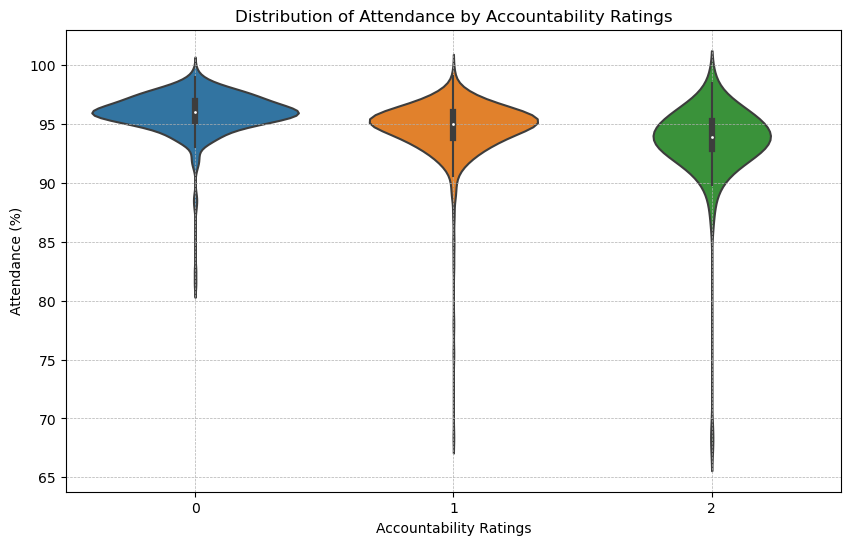

In [30]:
# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='ACCOUNTABILITY RATINGS', y='ATTENDANCE', data=completedf)
plt.title('Distribution of Attendance by Accountability Ratings')
plt.xlabel('Accountability Ratings')
plt.ylabel('Attendance (%)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('acc_attendance.png')
plt.show()

<Figure size 1000x600 with 0 Axes>

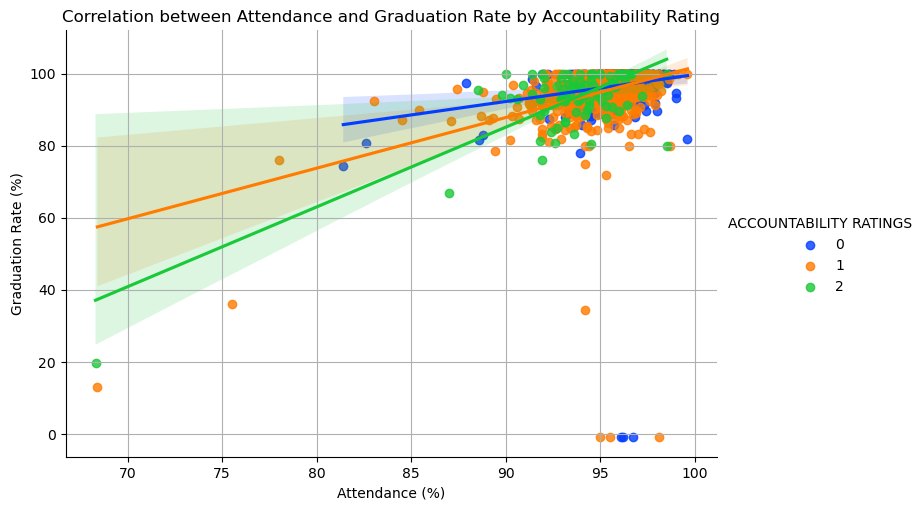

In [31]:
# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.lmplot(x='ATTENDANCE', y='GRADUATION RATE', data=completedf, hue='ACCOUNTABILITY RATINGS', palette='bright', aspect=1.5)

plt.title('Correlation between Attendance and Graduation Rate by Accountability Rating')
plt.xlabel('Attendance (%)')
plt.ylabel('Graduation Rate (%)')
plt.grid(True)
plt.show()

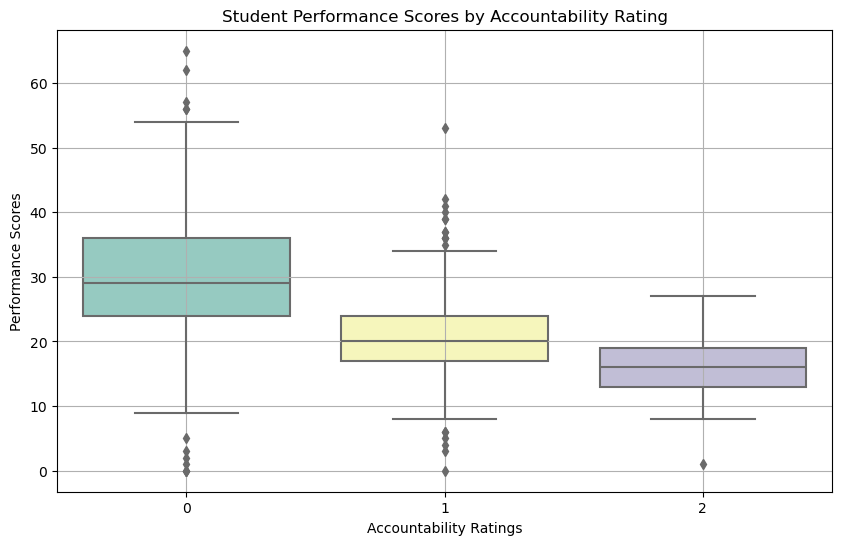

In [32]:
# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='ACCOUNTABILITY RATINGS', y= ' % ELA/READING AT MASTERS GRADE LEVEL', data=completedf, palette='Set3')

plt.title('Student Performance Scores by Accountability Rating')
plt.xlabel('Accountability Ratings')
plt.ylabel('Performance Scores')
plt.grid(True)
plt.savefig('boxplot.png')
plt.show()